In [ ]:
!pip install pyro-ppl

     |████████████████████████████████| 614kB 2.8MB/s 


In [ ]:
import torch
import pyro
pyro.__version__

'1.5.0'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## 1. Functions

In [ ]:
from pyro.nn import PyroModule, PyroSample, PyroParam
import pyro.distributions as dist

(array([  4.,  17.,  44., 101., 219., 280., 197., 101.,  29.,   8.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

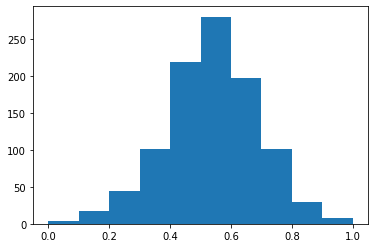

In [ ]:
def scale_minmax(x):
    vmin, vmax = torch.min(x), torch.max(x)
    return (x - vmin)/(vmax-vmin)

arr = scale_minmax(torch.randn(1000))
arr.shape
plt.hist(arr.data.numpy())

In [ ]:
def visualize(loss_track, param_track, approx):
    plt.plot(range(len(loss_track)), loss_track)
    plt.title('Loss')
    plt.show()

    param_names = param_track[0].keys()
    for param_name in param_names:
        param_value = [param[param_name] for param in param_track]
        plt.plot(range(len(param_value)), param_value)
        plt.title(param_name)
        plt.show()
    plt.hist(approx)
    plt.show()

## 2. Models

In [ ]:
class Demo(PyroModule):
    def __init__(self, dim = 1000):
        super(Demo, self).__init__()
        self.dim = dim
        self.phi = PyroParam(dist.Uniform(0, 1), event_dim = 1)
        self.tau = PyroParam(dist.Uniform(0, 1), event_dim = 1)

    def forward(self):
        with pyro.plate("obs", len(arr)):
            return pyro.sample("x", dist.Normal(loc = self.phi, scale = self.tau), obs = arr)

    def get_param(self):
        return {"phi":self.phi.item(), "tau": self.tau.item()}

    def get_approx(self, n_sample=1000):
        return dist.Normal(loc=self.phi, scale=self.tau).sample([n_sample])

def guide():
    pass

In [ ]:
from pyro.optim import Adam
from pyro.infer import Trace_ELBO, SVI
from pyro.infer.autoguide import AutoDiagonalNormal

pyro.clear_param_store()

adam_params = {"lr": 0.005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

model = Demo()
# guide = AutoDiagonalNormal(model)

svi = SVI(model, guide, optimizer, loss=Trace_ELBO(retain_graph=True))

epochs  = 100
view_step = epochs/10

loss_track, param_track = [], []
for step in range(epochs):
    loss = svi.step()
    loss_track.append(loss)
    params = model.get_param()
    param_track.append(params)
    if loss < 0:
        print ('early stopping')
        break
    if (step==0) or (step % view_step == view_step-1):
        print ("Step %d" % step)
        r = dist.Normal(torch.tensor([params['phi']]), torch.tensor([params['tau']])).sample([1000])
        rmse = np.sqrt(np.mean((r.data.numpy() - arr.data.numpy())**2))
        print ('+ Loss = %.6f, RMSE = %.6f: ' % (loss, rmse))
        print ('+ Param: ', params)

Step 0
+ Loss = 776.242493, RMSE = 0.884221: 
+ Param:  {'phi': 0.32033199071884155, 'tau': 0.8137328028678894}
Step 9
+ Loss = 710.652832, RMSE = 0.787769: 
+ Param:  {'phi': 0.36515113711357117, 'tau': 0.7686013579368591}
Step 19
+ Loss = 634.527710, RMSE = 0.731885: 
+ Param:  {'phi': 0.41374877095222473, 'tau': 0.7177609205245972}
Step 29
+ Loss = 554.466675, RMSE = 0.670179: 
+ Param:  {'phi': 0.4593612253665924, 'tau': 0.6656578183174133}
Step 39
+ Loss = 469.686920, RMSE = 0.616678: 
+ Param:  {'phi': 0.49949097633361816, 'tau': 0.6119162440299988}
Step 49
+ Loss = 378.726471, RMSE = 0.583304: 
+ Param:  {'phi': 0.5309038758277893, 'tau': 0.5563144683837891}
Step 59
+ Loss = 278.851715, RMSE = 0.537757: 
+ Param:  {'phi': 0.5502755641937256, 'tau': 0.49870845675468445}
Step 69
+ Loss = 165.968918, RMSE = 0.463949: 
+ Param:  {'phi': 0.5562737584114075, 'tau': 0.4389343559741974}
Step 79
+ Loss = 35.796581, RMSE = 0.407630: 
+ Param:  {'phi': 0.5524041056632996, 'tau': 0.37675362

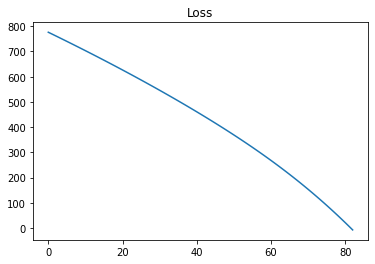

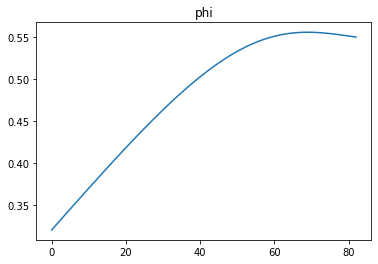

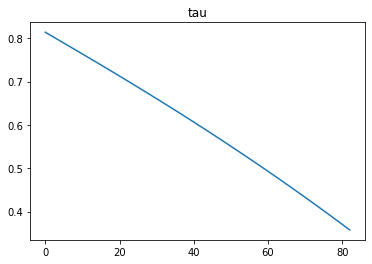

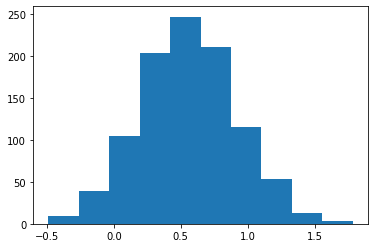

In [ ]:
visualize(loss_track, param_track, model.get_approx())

In [ ]:
# class Demo2(PyroModule):
#     def __init__(self, dim = 1000):
#         super(Demo2, self).__init__()
#         self.dim = dim
#         self.phi = PyroParam(dist.Uniform(0, 1), event_dim = 1)
#         self.tau = PyroParam(dist.Uniform(0, 1), event_dim = 1)
#         self.z, self.x = None, None

#     def forward(self):
#         self.z = PyroSample(dist.Normal(loc=self.phi, scale=self.tau))
#         self.x = PyroSample(dist.Normal(loc = self.z, scale=0.1).expand([self.dim]).to_event(1))
#         return self.x

#     def get_param(self):
#         return {"phi":self.phi.item(), "tau": self.tau.item()}

#     def get_approx(self, n_sample=1000):
#         return dist.Normal(loc=param_track[-1]['phi'], scale=param_track[-1]['tau']).sample([n_sample])

In [ ]:
class Demo2(PyroModule):
    def __init__(self, dim = 1000):
        super(Demo2, self).__init__()
        self.dim = dim
        self.phi = PyroParam(dist.Uniform(0, 1), event_dim = 1)
        self.tau = PyroParam(dist.Uniform(0, 1), event_dim = 1)
        self.x = None

    def forward(self):
        self.x = PyroSample(dist.Normal(loc=self.phi, scale=self.tau).expand([self.dim]).to_event(1))
        return self.x

    def get_param(self):
        return {"phi":self.phi.item(), "tau": self.tau.item()}

    def get_approx(self, n_sample=1000):
        return dist.Normal(loc=self.phi, scale=self.tau).sample([n_sample])

In [ ]:
pyro.clear_param_store()
demo2 = Demo2()
MSE_fn = torch.nn.MSELoss(reduction='mean')
optim   = torch.optim.Adam(demo2.parameters(), lr=0.01)

epochs  = 100
view_step = epochs/10
loss_track, param_track = [], []

for step in range(epochs):
    y = demo2().squeeze(-1)
    loss_MSE = MSE_fn(y, arr)

    loss_track.append(loss_MSE)
    param_track.append(demo2.get_param())

    optim.zero_grad()
    loss_MSE.backward(retain_graph=True)
    optim.step()

    if (step==0) or (step % view_step == view_step-1):
        print ("Epoch %d: " % step)
        print ("    + MSE Loss = %.6f" % loss_MSE)
        print ("    + Param: ", demo2.get_param())

Epoch 0: 
    + MSE Loss = 0.604347
    + Param:  {'phi': 0.5067212581634521, 'tau': 0.7360627055168152}
Epoch 9: 
    + MSE Loss = 0.454883
    + Param:  {'phi': 0.5533667802810669, 'tau': 0.6468510627746582}
Epoch 19: 
    + MSE Loss = 0.334533
    + Param:  {'phi': 0.5566205382347107, 'tau': 0.5513705015182495}
Epoch 29: 
    + MSE Loss = 0.251733
    + Param:  {'phi': 0.539281964302063, 'tau': 0.46049225330352783}
Epoch 39: 
    + MSE Loss = 0.164157
    + Param:  {'phi': 0.5443845391273499, 'tau': 0.37719497084617615}
Epoch 49: 
    + MSE Loss = 0.114044
    + Param:  {'phi': 0.5552552938461304, 'tau': 0.30309832096099854}
Epoch 59: 
    + MSE Loss = 0.078030
    + Param:  {'phi': 0.5445644855499268, 'tau': 0.23772229254245758}
Epoch 69: 
    + MSE Loss = 0.056683
    + Param:  {'phi': 0.5508555769920349, 'tau': 0.18166561424732208}
Epoch 79: 
    + MSE Loss = 0.039303
    + Param:  {'phi': 0.5505625605583191, 'tau': 0.1350698471069336}
Epoch 89: 
    + MSE Loss = 0.032863
    + P

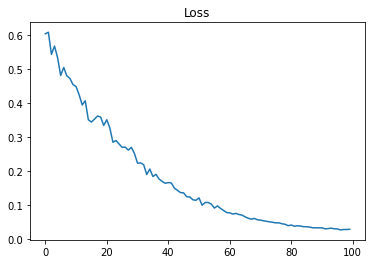

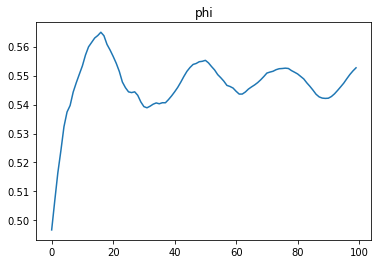

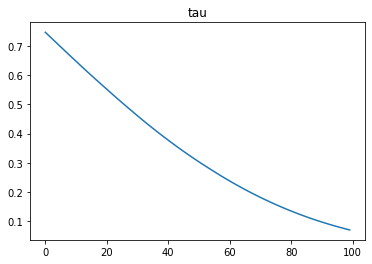

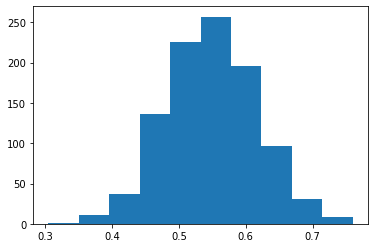

In [ ]:
visualize(loss_track, param_track, demo2.get_approx())

In [ ]:
class Demo3(PyroModule):
    def __init__(self, dim = 1000):
        super(Demo3, self).__init__()
        self.dim = dim
        self.phi = PyroParam(dist.Uniform(0, 1), event_dim = 1)
        self.x = None

    def forward(self):
        self.x = PyroSample(dist.Normal(loc=self.phi, scale=1.0).expand([self.dim]).to_event(1))
        return self.x

    def get_param(self):
        return {"phi":self.phi.item()}

    def get_approx(self, n_sample=1000):
        return dist.Normal(loc=self.phi, scale=1.0).sample([n_sample])

In [ ]:
pyro.clear_param_store()

demo3 = Demo3()
MSE_fn = torch.nn.MSELoss(reduction='mean')
optim   = torch.optim.Adam(demo3.parameters(), lr=0.001)

epochs  = 100
view_step = epochs/10
loss_track, param_track = [], []

for step in range(epochs):
    y = demo3().squeeze(-1)
    loss_MSE = MSE_fn(y, arr)

    loss_track.append(loss_MSE)
    param_track.append(demo3.get_param())

    optim.zero_grad()
    loss_MSE.backward(retain_graph=True)
    optim.step()

    if (step==0) or (step % view_step == view_step-1):
        print ("Epoch %d: " % step)
        print ("    + MSE Loss = %.6f" % loss_MSE)
        print ("    + Param: ", demo3.get_param())

Epoch 0: 
    + MSE Loss = 1.056842
    + Param:  {'phi': 0.4506656527519226}
Epoch 9: 
    + MSE Loss = 1.086563
    + Param:  {'phi': 0.4595448672771454}
Epoch 19: 
    + MSE Loss = 1.016145
    + Param:  {'phi': 0.4689931869506836}
Epoch 29: 
    + MSE Loss = 1.105044
    + Param:  {'phi': 0.47835174202919006}
Epoch 39: 
    + MSE Loss = 1.024042
    + Param:  {'phi': 0.4872571527957916}
Epoch 49: 
    + MSE Loss = 1.031289
    + Param:  {'phi': 0.49574515223503113}
Epoch 59: 
    + MSE Loss = 1.060596
    + Param:  {'phi': 0.5044065713882446}
Epoch 69: 
    + MSE Loss = 0.947104
    + Param:  {'phi': 0.5123645067214966}
Epoch 79: 
    + MSE Loss = 1.049952
    + Param:  {'phi': 0.5198954939842224}
Epoch 89: 
    + MSE Loss = 1.071834
    + Param:  {'phi': 0.5268571972846985}
Epoch 99: 
    + MSE Loss = 1.083476
    + Param:  {'phi': 0.5339112281799316}


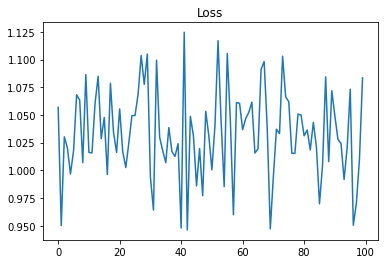

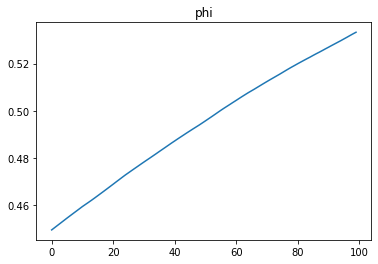

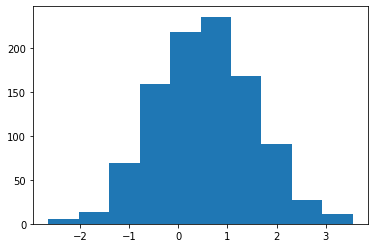

In [ ]:
visualize(loss_track, param_track, demo3.get_approx())

## Tutorials

http://pyro.ai/examples/modules.html